In [ ]:
### Drive Access

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### Importing the necessary libraries

import warnings
import sys
import io
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from matplotlib import pyplot
from sklearn import datasets
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso,Ridge
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from google.colab import drive
from google.colab import files
from collections import *
from math import sqrt,ceil,log2,floor,pi
from datetime import datetime
from copy import deepcopy

warnings.filterwarnings("ignore")

### Reading the csv file

np.random.seed(0)
notebookpath = "/content/drive/MyDrive/Colab Notebooks/SMA STD Bol Upper,Lower and also some extra new features.csv"
df = pd.read_csv(notebookpath)
#df

In [ ]:
### Function for calculating RMSE Range

def calculate_rmse_range(y_true,y_pred,left_r,right_r):
    # >left_r and <=right_r
    n_samples = 0;
    y_truen = []
    y_predn=[]
    maxval = max(y_true)
    minval = min(y_true)
    for i in range(len(y_true)):
        score = (y_true[i] - minval)/(maxval - minval)
        if score>=left_r and score<=right_r:
            y_truen.append(y_true[i])
            y_predn.append(y_pred[i])
    if len(y_truen)>0:
        # print(minval,maxval)
        print((maxval-minval)*left_r+minval,(maxval-minval)*right_r+minval)
        return sqrt(mean_squared_error(y_truen,y_predn))
    return 0

In [ ]:
### Dropping less relevant columns

df = df.drop(columns = ['Symbol','Series','Volume','VWAP','Deliverable Volume','%Deliverble'], axis = 1)

In [ ]:
### Preprocessing data for Multiple Linear Regression

lastcol = len(df.columns)
dfnum = df[df.columns[list(range(2,lastcol))]]
cols = list(dfnum.columns)
meantrades = df['Trades'].mean()
#print(meantrades)
df['Trades'].fillna(value=meantrades, inplace=True)
#print(cols)
#print(dfnum)
dfscaled = pd.DataFrame(df, columns = cols)
dfscaled.head()
targetfeature = 'Close'
#dfscaled.columns

In [ ]:
### Performing Multi-linear Regression for different time windows

windows = [5*i for i in range(1,5)]
tsterr, trainerr,valerr = [], [], []
error_on_low=[]
error_on_mid=[]
error_on_high=[]
j = 0;

for window in windows:
  #Transform Function for making windows
  def transform(dfscaled, win):
    df2 = deepcopy(dfscaled)
    col = df2.columns
    for i in range(2, win+1):
      for c in col:
        df2[c+str(i)] = df2[c].shift(-(i-1)) #stepback i-1 times
        df2['Close'+str(win+1)] = df2['Close'].shift(-(win)) #stepback i-1 times
    return df2
  print("window"+str(window))
  df2 = transform(dfscaled, window)
  df2 = df2.dropna()
  # print(df2)
  # df2.drop(columns = [])
    
  MLR = LinearRegression()

  #Splitting the dataset
  trainn = deepcopy(df2.loc[0:1900])
  valt = deepcopy(df2.loc[1900:2100])
  testt = deepcopy(df2.loc[2100:2300])
  trainnY = trainn["Close"+str(window+1)].values
  del trainn["Close"+str(window+1)]
  trainn.drop(columns=[])
  trainnX = trainn.values.astype(np.float64)
  valtY = testt["Close"+str(window+1)].values
  del valt["Close"+str(window+1)]
  valtX = valt.values.astype(np.float64)
  testtY = testt["Close"+str(window+1)].values
  del testt["Close"+str(window+1)]
  testtX = testt.values.astype(np.float64) 
  # print("trainnx")
  # print(trainnX)
  # print(trainnX.shape)
  # print("trainny")
  # print(trainnY)
  # print("testtx")
  # print(testtX)
  # print(testtX.shape)
  # print("testtY")
  # print(testtY)
  modela = PCA(n_components = 35*(j+1))
  # trainnX=modela.fit_transform(trainnX)
  MLR.fit(trainnX, trainnY)
  trainp = MLR.predict(trainnX)
  # testtX = modela.transform(testtX)
  # valtX = modela.transform(valtX)
  testp = MLR.predict(testtX)
  valp = MLR.predict(valtX)

  trainerr.append(sqrt(mean_squared_error(trainnY, trainp)))
  tsterr.append(sqrt(mean_squared_error(testtY, testp))) 
  valerr.append(sqrt(mean_squared_error(valtY,valp)))
  print("Range of Closing price for Low:")
  err1 = calculate_rmse_range(testtY,testp,0,0.35)
  print("Range of Closing price for Mid:")
  err2 = calculate_rmse_range(testtY,testp,0.35,0.7)
  print("Range of Closing price for High:")
  err3 = calculate_rmse_range(testtY,testp,0.7,1)
  error_on_low.append(err1)
  error_on_mid.append(err2)
  error_on_high.append(err3)
  #print(testp)
  #print(testpp)
  print("Test Error on different ranges of close price :")
  outt = "{:.2f} {:.2f} {:.2f}"
  print(outt.format(float(err1), float(err2),float(err3)))
  j+=1
  if(j-1==0):
    pickle.dump(MLR, open('MLR_5.pkl', 'wb'))
  if(j-1==1):
    pickle.dump(MLR, open('MLR_10.pkl', 'wb'))
  if(j-1==2):
    pickle.dump(MLR, open('MLR_15.pkl', 'wb'))
  if(j-1==3):
    pickle.dump(MLR, open('MLR_20.pkl', 'wb'))

window5
Range of Closing price for Low:
250.75 301.5525
Range of Closing price for Mid:
301.5525 352.35499999999996
Range of Closing price for High:
352.35499999999996 395.9
Test Error on different ranges of close price :
6.75 9.03 5.38
window10
Range of Closing price for Low:
255.7 311.1925
Range of Closing price for Mid:
311.1925 366.685
Range of Closing price for High:
366.685 414.25
Test Error on different ranges of close price :
6.73 9.05 6.38
window15
Range of Closing price for Low:
255.7 311.385
Range of Closing price for Mid:
311.385 367.07
Range of Closing price for High:
367.07 414.8
Test Error on different ranges of close price :
6.66 9.78 7.83
window20
Range of Closing price for Low:
255.7 311.385
Range of Closing price for Mid:
311.385 367.07
Range of Closing price for High:
367.07 414.8
Test Error on different ranges of close price :
7.63 9.61 8.11


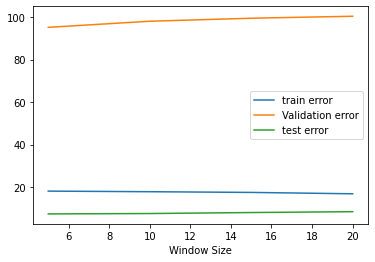

In [ ]:
### Plotting the errors for Window Sizes

plt.plot(windows,trainerr,label = "train error")
plt.plot(windows,valerr,label = "Validation error")
plt.plot(windows,tsterr,label = "test error")
plt.xlabel("Window Size")
plt.legend()
plt.show()

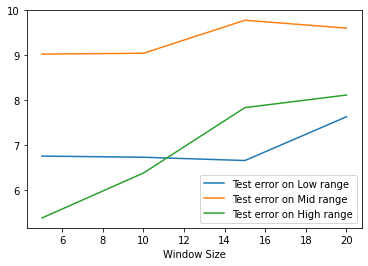

In [ ]:
### Plotting test error on different ranges

plt.plot(windows,error_on_low,label = "Test error on Low range")
plt.plot(windows,error_on_mid,label = "Test error on Mid range")
plt.plot(windows,error_on_high,label = "Test error on High range")
plt.xlabel("Window Size")
plt.legend()
plt.show()

In [ ]:
### Printing the error
trainerr = [round(x,2) for x in trainerr]
tsterr = [round(x,2) for x in tsterr]
valerr = [round(x,2) for x in valerr]
print(trainerr)
print(tsterr)
print(valerr)

[18.11, 17.84, 17.5, 16.86]
[7.39, 7.57, 8.05, 8.44]
[95.13, 98.0, 99.42, 100.35]


In [ ]:
### Performing Multilinear Regression with Ridge Regularization for different time windows

windows = [5*i for i in range(1,5)]
tsterr, trainerr,valerr = [], [], []
error_on_low=[]
error_on_mid=[]
error_on_high=[]
j = 0;

for window in windows:
  #Transform Function for making windows
  def transform(dfscaled, win):
    df2 = deepcopy(dfscaled)
    col = df2.columns
    for i in range(2, win+1):
      for c in col:
        df2[c+str(i)] = df2[c].shift(-(i-1)) #stepback i-1 times
        df2['Close'+str(win+1)] = df2['Close'].shift(-(win)) #stepback i-1 times
    return df2
  print("window"+str(window))
  df2 = transform(dfscaled, window)
  df2 = df2.dropna()
  # print(df2)
  # df2.drop(columns = [])
    
  MLR = Ridge(alpha = 1.5,max_iter = 1500)
  trainn = deepcopy(df2.loc[0:1900])
  valt = deepcopy(df2.loc[1900:2100])
  testt = deepcopy(df2.loc[2100:2300])

  trainnY = trainn["Close"+str(window+1)].values
  del trainn["Close"+str(window+1)]
  trainn.drop(columns=[])
  trainnX = trainn.values.astype(np.float64)
  valtY = testt["Close"+str(window+1)].values
  del valt["Close"+str(window+1)]
  valtX = valt.values.astype(np.float64)
  testtY = testt["Close"+str(window+1)].values
  del testt["Close"+str(window+1)]
  testtX = testt.values.astype(np.float64) 

  # print("trainnx")
  # print(trainnX)
  # print(trainnX.shape)
  # print("trainny")
  # print(trainnY)
  # print("testtx")
  # print(testtX)
  # print(testtX.shape)
  # print("testtY")
  # print(testtY)
  modela = PCA(n_components = 35*(j+1))
  # trainnX=modela.fit_transform(trainnX)
  MLR.fit(trainnX, trainnY)
  trainp = MLR.predict(trainnX)
  # testtX = modela.transform(testtX)
  # valtX = modela.transform(valtX)

  testp = MLR.predict(testtX)
  valp = MLR.predict(valtX)

  trainerr.append(sqrt(mean_squared_error(trainnY, trainp)))
  tsterr.append(sqrt(mean_squared_error(testtY, testp))) 
  valerr.append(sqrt(mean_squared_error(valtY,valp)))
  print("Range of Closing price for Low:")
  err1 = calculate_rmse_range(testtY,testp,0,0.35)
  print("Range of Closing price for Mid:")
  err2 = calculate_rmse_range(testtY,testp,0.35,0.7)
  print("Range of Closing price for High:")
  err3 = calculate_rmse_range(testtY,testp,0.7,1)
  error_on_low.append(err1)
  error_on_mid.append(err2)
  error_on_high.append(err3)
  #print(testp)
  #print(testpp)

  print("Test Error on different ranges of close price :")
  outt = "{:.2f} {:.2f} {:.2f}"
  print(outt.format(float(err1), float(err2),float(err3)))
  j+=1
  if(j-1==0):
    pickle.dump(MLR, open('MLR_Ridge_5.pkl', 'wb'))
  if(j-1==1):
    pickle.dump(MLR, open('MLR_Ridge_10.pkl', 'wb'))
  if(j-1==2):
    pickle.dump(MLR, open('MLR_Ridge_15.pkl', 'wb'))
  if(j-1==3):
    pickle.dump(MLR, open('MLR_Ridge_20.pkl', 'wb'))

window5
Range of Closing price for Low:
250.75 301.5525
Range of Closing price for Mid:
301.5525 352.35499999999996
Range of Closing price for High:
352.35499999999996 395.9
Test Error on different ranges of close price :
6.79 8.97 5.20
window10
Range of Closing price for Low:
255.7 311.1925
Range of Closing price for Mid:
311.1925 366.685
Range of Closing price for High:
366.685 414.25
Test Error on different ranges of close price :
6.68 9.18 6.41
window15
Range of Closing price for Low:
255.7 311.385
Range of Closing price for Mid:
311.385 367.07
Range of Closing price for High:
367.07 414.8
Test Error on different ranges of close price :
6.56 9.51 7.44
window20
Range of Closing price for Low:
255.7 311.385
Range of Closing price for Mid:
311.385 367.07
Range of Closing price for High:
367.07 414.8
Test Error on different ranges of close price :
7.61 9.60 7.84


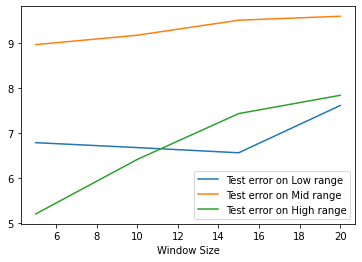

In [ ]:
plt.plot(windows,error_on_low,label = "Test error on Low range")
plt.plot(windows,error_on_mid,label = "Test error on Mid range")
plt.plot(windows,error_on_high,label = "Test error on High range")
plt.xlabel("Window Size")
plt.legend()

plt.show()

In [ ]:
trainerr = [round(x,2) for x in trainerr]
tsterr = [round(x,2) for x in tsterr]
valerr = [round(x,2) for x in valerr]
print(trainerr)
print(tsterr)
print(valerr)
# sorted(testtY)

[18.1, 17.8, 17.46, 16.81]
[7.35, 7.61, 7.83, 8.38]
[94.93, 98.07, 99.18, 100.25]
